# Clasificación desde la Econometría

## Casos de Uso

- Los problemas de clasificación corresponden a un ejemplo de aprendizaje supervisado donde el vector objetivo responde a un atributo **discreto (clases)**.
- Existen muchos fenómenos cuya primera aproximación es mediante la binarización: ¿existe o no existe una condición?
- Esta aproximación toma forma de un ensayo de Bernoulli

**Ejemplos**
- Movimientos del mercado: ¿Bajará o subirá la bolsa?
- Clasificación de Spam: ¿Es este mail Spam o No?
- Optimización de Preferencias: ¿Es más probable votar o no?
<br />
<br />

**Ejemplo pozos**

Usaremos una base de datos donde se registró si un hogar comenzó a utilizar un nuevo pozo de napa subterránea o no. Así, clasificaremos como 1 si el hogar se cambió a un pozo nuevo, 0 de lo contrario. 

In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from funciones import plot_ll, plot_ll_logit, crossvalidation_schema

plt.style.use("seaborn")
sns.set(style=None, font_scale=1.5)

df = pd.read_csv("wells.csv").drop(columns=["index"])
df.head()

,y,dist100,arsenic,educ4,assoc
0,1,0.16826,2.36,0.0,0
1,1,0.47322,0.71,0.0,0
2,0,0.20967,2.07,2.5,0
3,1,0.21486,1.15,3.0,0
4,1,0.40874,1.10,3.5,1


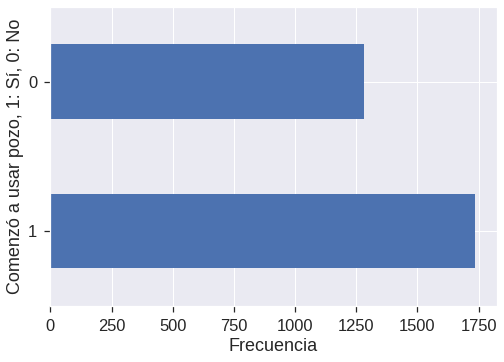

In [2]:
df["y"].value_counts().plot(kind="barh")
plt.xlabel("Frecuencia")
plt.ylabel("Comenzó a usar pozo, 1: Sí, 0: No");

## Modelo de Probabilidad Lineal

- **Primera aproximación**: Utilizar una regresión lineal asumiendo que nuestra variable dependiente mide la _probabilidad_ (valor entre 0 y 1) de suceso.

$$
y_i = \beta_0 + \beta_{dist100} \cdot \text{dist100}_i + \epsilon_i
$$

- Es decir, aplica el modelo de _regresión lineal_, el cual considera como objetivo una variable **continua**. Pero como nuestro objetivo en clasificación es de tipo **categórico**, lo que se hace es considerar al objetivo no como clases 0 y 1, sino como _una probabilidad_ (que es continua) _entre_ 0 y 1.
<br />
<br />
- La interpretación de los coeficientes se hace en consideración a la probabilidad de ocurrencia del suceso.
- Con nuestro $\hat y$ podemos clasificar una observación como 1 si $\hat y \geq 0.5$, de lo contrario 0.

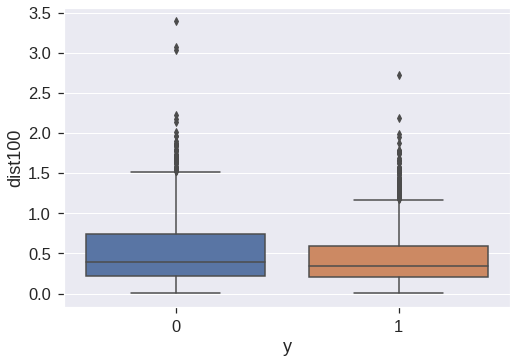

In [3]:
sns.boxplot(x=df["y"], y=df["dist100"]);

- Los que se cambiaron a un pozo en promedio estaban a menor distancia de un pozo que los que no se cambiaron

In [4]:
m1_ols = smf.ols('y ~ dist100', df).fit()

# Coeficientes
m1_ols.summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,0.648407,0.014347,45.194138,0.000000e+00,0.620276,0.676539
dist100,-0.151539,0.023225,-6.524825,7.954898e-11,-0.197078,-0.106001


- El intercepto $\beta_0$ se puede interpretar al considerar $\text{dist100}=0$. Una familia que esté a 0 metros de distancia de un pozo tendrá una probabilidad del 65% de cambiarse de pozo (asumiendo que está limpio).
- $\beta_{dist100}$ se puede interpretar como la diferencia entre dos individuos que tienen similares características pero difieren en 100 metros de distancia de un pozo seguro, conlleva a una disminución de un 15% en la probabilidad de cambiarse de pozo.

### Limitantes del Modelo de Probabilidad Lineal
El modelo de probabilidad lineal presenta fallas en la estimación:
- Es muy sensible a valores atípicos.
- Los errores no siguen una distribución normal.
- La forma funcional lineal restringe las no linealidades en los extremos de la muestra.
- Las predicciones pueden ser cualquier valor real, mientras que las probabilidades se restringen a valores entre 0 y 1.

In [5]:
import numpy as np
from scipy import stats

# Datos sin outliers para dist100 (con puntaje x menor a |3|)
df_sin_out = df[(np.abs(stats.zscore(df["dist100"])) < 3)]
df.shape, df_sin_out.shape

((3020, 5), (2972, 5))

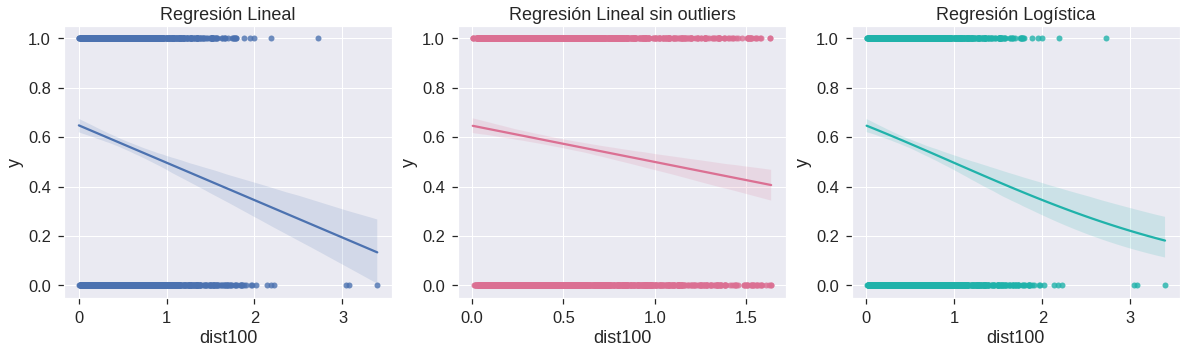

In [6]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
sns.regplot(x="dist100", y="y", data=df)
plt.title("Regresión Lineal")

plt.subplot(1, 3, 2)
sns.regplot(x="dist100", y="y", data=df_sin_out, color="palevioletred")
plt.title("Regresión Lineal sin outliers")

plt.subplot(1, 3, 3)
sns.regplot(x="dist100", y="y", data=df, logistic=True, color="lightseagreen")
plt.title("Regresión Logística");

## Regresión Logística

- La estimación de los coeficientes en la regresión logística se realiza mediante el método de **máxima verosimilitud**:
    <br />
    <br />
    
    - Busca la "línea curva" del modelo encontrando los parámetros (coeficientes) que mejor se ajusten (tenga más verosimilitud), dado los datos que poseemos. 
    <br />
    <br />
    
    - A diferencia de la regresión lineal, la forma de encontrar estos "parámetros óptimos" _no es cerrada_ (no pueden obtenerse "directamente"), por lo que se debe aplicar el uso de un _gradiente_ (normalmente gradiente estocástico descendente).
    <br />
    <br />
    - En términos sobresimplificados, esto quiere decir que se debe ir itereando "hasta encontrar" el modelo con _mayor probabilidad de haber generado los datos_ (ajusta por verosimilitud, no por error).


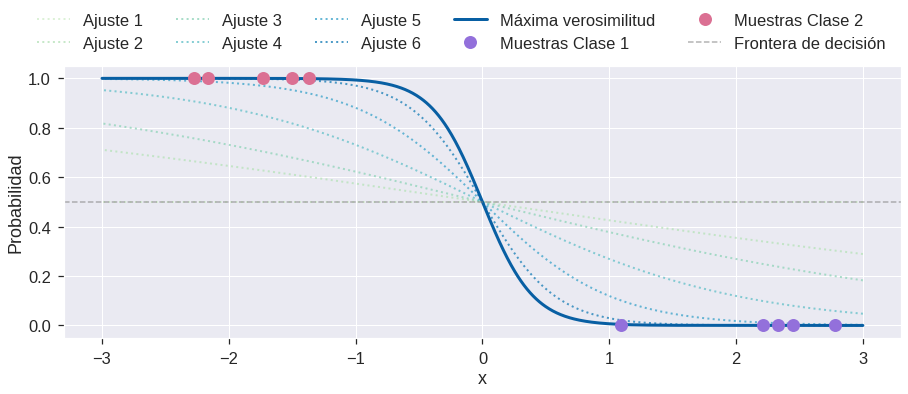

In [7]:
plt.figure(figsize=(15, 5))
_, _ = plot_ll(lims=(3, -3), weights=[0, 0.3, 0.5, 1, 2, 3.5, 5], n=5)

### Función Logit

_**¿Cómo logramos ajustar la "linea curva" de la máxima verosimilitud?**_

- Lo que en realidad hacemos es _realizar una transformación de las probabilidades_, de modo que lo que se ajuste finalmente _sea hacia una recta_.
- Para ello, utilizaremos la función _logit_, que corresponde al inverso de la función logística.
- También se le llama "log odds", ya que entrega _el logaritmo de las "chances"_, o de las "oportunidades de ocurrencia". Las "chances" (odds) son números reales.
- De esta forma, las **probabilidades originales** son _transformadas_ a valores que van desde $-\infty$ hasta $+\infty$ (los **log odds**), y que son posibles de dibujar en una recta a la cual se puede encontrar el ajuste utilizando la combinación lineal de parámetros.
- Por tanto, el modelo entrenado estará ajustado no a las probabilidades, _sino que a los logaritmos de las chances de ocurrencia_.
    - **Nota**: Se utiliza los _logaritmos_ porque esto permite realizar sumas en lugar de multiplicaciones, lo que facilita el cálculo.

$$
\log{\left(\frac{p(x)}{1 - p(x)}\right)} = \beta_0 + \beta_{dist100} \cdot \text{dist100}
$$

- $p(x)$: $p(Y=1 | X=x)$. Probabilidad de que el vector objetivo sea de la clase 1, dado un valor específico de $X$ (que en este caso corresponde a $\text{dist100}$).
- $\frac{p(x)}{1 - p(x)}$: Oportunidad de ocurrencia

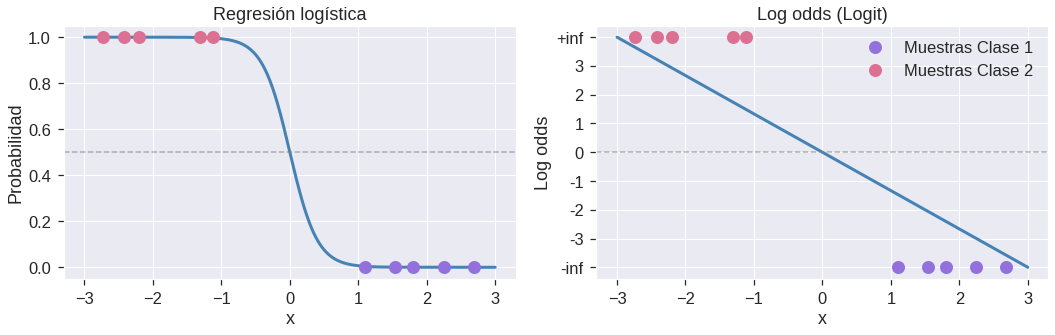

In [8]:
np.random.seed(42)
plot_ll_logit()

In [9]:
from scipy.special import logit

for p in [0, 0.05, 0.1, 0.25, 0.5, 0.75, 0.88, 0.95, 1]:
    logodds = logit(p)
    print(f"Una probabilidad de {p} equivale a {logodds if logodds in [np.inf, -np.inf] else round(logodds)} log odds")

Una probabilidad de 0 equivale a -inf log odds
Una probabilidad de 0.05 equivale a -3 log odds
Una probabilidad de 0.1 equivale a -2 log odds
Una probabilidad de 0.25 equivale a -1 log odds
Una probabilidad de 0.5 equivale a 0 log odds
Una probabilidad de 0.75 equivale a 1 log odds
Una probabilidad de 0.88 equivale a 2 log odds
Una probabilidad de 0.95 equivale a 3 log odds
Una probabilidad de 1 equivale a inf log odds


_Referencias_
- https://www.youtube.com/watch?v=vN5cNN2-HWE
- https://www.youtube.com/watch?v=BfKanl1aSG0

**Problema**
- Como de esta forma el eje $y$ va desde $-\infty$ hasta $+\infty$, esto significa que los errores también pueden tener _valores infinitos_.
- Por lo tanto, _no es posible utilizar OLS_ para encontrar la recta de mejor ajuste, y por esta razón, se usa la _máxima verosimilitud_.
<br />
<br />

**Veamos ahora la aplicación en Python...**
- Para este caso, el modelo toma 4 iteraciones en llegar al ajuste óptimo.

In [10]:
# Aplicamos la regresión usando logit de statsmodels.formula
m1_logit = smf.logit('y ~ dist100', df).fit()

Optimization terminated successfully.
         Current function value: 0.674874
         Iterations 4


### Bondad de Ajuste

- La bondad de ajuste en los modelos estimados se evalúa con las métricas de Log-Likelihood.
- Buscamos encontrar un máximo de verosimilitud en una función: Esto implica un problema de optimización $\text{argmin}$:
    - Se minimiza la log verosimilitud negativa
    - Esto es equivalente a maximizar la verosimilitud, pero normalmente los optimizadores minimizan, por eso se minimiza la log verosimilitud negativa
- Existen dos métricas de interés:
    - Log-Likelihood: La verosimilitud del modelo ajustado.
    - LL-Null: La verosimilitud del modelo sin regresores.
    
- En general, se debe comparar 2 o más modelos para decidir cuál posee el mejor ajuste (mayor log likelihood, o "más cercana a 0").

In [11]:
m1_logit.llf, m1_logit.llnull

(-2038.11891291195, -2059.0496087126576)

### Interpretación de Coeficientes

- **Importante**: No debemos interpretar los coeficientes como lineales.
- En la regresión logística los coeficientes estimados corresponden a los logaritmos de las chances de ocurrencia en el cambio en una unidad de x.
- El problema con la interpretación de los coeficientes como log-odds es que no tiene sentido para nosotros.

In [12]:
m1_logit.params

Intercept    0.605959
dist100     -0.621882
dtype: float64

- Podríamos estar tentados a interpretar los coeficientes como: "La diferencia entre dos individuos que tienen similares características pero difieren en 100 metros de distancia de un pozo seguro, conlleva a una disminución de un .62 en la probabilidad de cambiarse de pozo".
- Esto _**no es correcto**_, dado que los parámetros estimados mediante la regresión logística corresponden a log-odds, que representan el logaritmo de la oportunidad (chance) de ocurrencia de un evento en específico.
- Esto obliga a tomar con cautela el cómo se deben interpretar.

### De log-odds a probabilidad

**Pero estamos ajustando una _recta_ entre $-\infty$ y $+\infty$!, ¿Cómo determinamos _la clase_ a la que pertenece una combinación específica de atributos?**
- El objetivo es traducir de _log-odds_ a una declaración probabilística. Así generamos una explicación intuitiva sobre el efecto de una variable en la probabilidad de ocurrencia.
    - Esto lo podemos lograr con la función logística (inverso de la función logit):
    
$$
\text{logit}^{-1}(x) = \text{logistic}(x) = \frac{1}{1 + exp(-x)}
$$

- $x$: _Log-odds_ = $\beta_0 + \beta_{1} \cdot X_1,...,\beta_{m} \cdot X_m$
- Esto nos da como resultado una probabilidad entre 0 y 1.
- Usualmente, se considerará como _clase 1_ a los resultados de probabilidad obtenidos mayores o iguales a 0.5, y como _clase 0_ a los resultados de probabilidad obtenidos menores a 0.5.
<br />
<br />

**Ejemplo** 

_¿Cuánto es la probabilidad de cambiarse a un pozo seguro si se vive a una distancia de 48 metros?_

In [13]:
# Definimos la función logística
def invlogit(x):
    return 1 / (1+np.exp(-x))

# Calculamos Beta0 + Beta1 * 48 metros
estimate_y = m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 0.48)
prob_cambiarse_de_pozo = invlogit(estimate_y)

print("El log odds estimado es de ", round(estimate_y, 2))
print(f"La probabilidad promedio de cambiarse de pozo cuando tenemos una distancia de 48 metros es: ", round(prob_cambiarse_de_pozo, 2))
print(f"{'Sí se cambiaría de pozo' if prob_cambiarse_de_pozo > 0.5 else 'No se cambiaría de pozo'}")

El log odds estimado es de  0.31
La probabilidad promedio de cambiarse de pozo cuando tenemos una distancia de 48 metros es:  0.58
Sí se cambiaría de pozo


### Efecto Diferencial

- Al convertir una combinación lineal de log-odds estamos obteniendo la probabilidad de un punto específico.
- Para evaluar la contribución de X en la probabilidad de ocurrencia, debemos hacer lo siguiente:
    - Obtener la probabilidad de ocurrencia en escenario 1: $p(y=1 | \text{dist100} = 100) = \text{logit}^{-1}(\beta_0 + \beta_{dist100} \cdot 1)$
    - Obtener la probabilidad de ocurrencia en escenario 1: $p(y=1 | \text{dist100} = 200) = \text{logit}^{-1}(\beta_0 + \beta_{dist100} \cdot 2)$
    - Restar ambas probabilidades: $p(y=1 | \text{dist100} = 100) - p(y=1 | \text{dist100} = 200)$

In [15]:
pr_dist_100, pr_dist_200

(0.4960194411878717, 0.3457430029920144)

In [14]:
# Escenario 1
pr_dist_100 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 1))

# Escenario 2
pr_dist_200 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 2))

print("La probabilidad de cambiar de pozo entre 100 y 200 metros: ", round(pr_dist_100 - pr_dist_200, 3))

La probabilidad de cambiar de pozo entre 100 y 200 metros:  0.15


- El tránsito entre distintos valores conlleva a distintos cambios en las probabilidades.
- Este es uno de los principales motivos de esta cautela en la interpretación del modelo logístico: _No se puede asumir monotonicidad estricta en los parámetros_.
- La probabilidad de un cambio entre 100 y 200 $p(x) = .15$ es distinta a la probabilidad entre 200 y 300 $p(x)= .125$.

In [16]:
# Escenario 3
pr_dist_300 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 3))

print("La probabilidad de cambiar de pozo entre 200 y 300 metros: ", round(pr_dist_200 - pr_dist_300, 3))

La probabilidad de cambiar de pozo entre 200 y 300 metros:  0.125


### Punto equidistante

- Podemos inferir en qué puntaje de $x_1$ nos encontraremos con el caso equiprobable.
- Esto se conoce como dosis letal media en la literatura bioestadística.

$$
x_1 = \frac{-\hat \beta_0}{\hat \beta_1}
$$

Una observación tiene igual probabilidad en ambos sucesos cuando x =  0.974


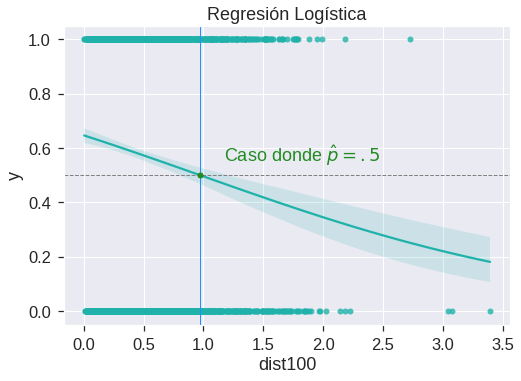

In [17]:
# Punto equidistante
decision_boundary = - m1_logit.params['Intercept'] / m1_logit.params['dist100']

sns.regplot(x="dist100", y="y", data=df, logistic=True, color="lightseagreen")
plt.axvline(decision_boundary, lw=1, color='dodgerblue')
plt.axhline(.5, linestyle='--', color='grey', lw=1)
plt.text(decision_boundary+.2, .5+.05, r'Caso donde $\hat{p}=.5$', color='forestgreen')
plt.plot(decision_boundary, .5, 'o', color='forestgreen')
plt.title("Regresión Logística")
print("Una observación tiene igual probabilidad en ambos sucesos cuando x = ", round(decision_boundary, 3));

## Relación entre LPM y Logit
- Podemos tomar los log-odds de un modelo logístico y dividirlos por cuatro para obtener un intervalo superior de la contribución de $x$ en y cuánto cambia en una medida.
- Este punto es una _aproximación_ al comportamiento estimado en el medio de la curva logística donde las probabilidades son cercanas al .5.
- Así, $\frac{\beta_1}{4}$ es la diferencia máxima de $p(y = 1|x)$

In [18]:
m1_logit.params["dist100"] / 4, m1_ols.params["dist100"]

(-0.15547048281514708, -0.1515394116409659)

- Este coeficiente corresponde a la _máxima diferencia_ contribuída por $x$ en $p(y = 1|x)$.
- Si revisamos nuestros efectos estimados, observaremos que el .15 estimado corresponde a la diferencia en un 15% de probabilidad entre una familia que está a 100 metros de distancia y otra que está a 200 metros de distancia de un pozo seguro.

In [19]:
print("La probabilidad de cambiar de pozo entre 100 y 200 metros: ", round(pr_dist_100 - pr_dist_200, 3))

La probabilidad de cambiar de pozo entre 100 y 200 metros:  0.15


# Clasificación desde Machine Learning

## Implementando un modelo logístico con sklearn

- Utilizaremos la clase `LogisticRegression` dentro del módulo `linear_model` de `sklearn`.
- Como en todo flujo de machine learning, se debe generar los 4 subsets de muestra para train y test.
- Las predicciones se pueden realizar para obtener las _probabilidades_ mediante `predict_proba`, o para obtener las _clases_ mediante `predict`

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df.copy()
y = X.pop("y")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=11238)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2023, 4), (997, 4), (2023,), (997,))

In [21]:
# Se entrena modelo con los atributos de clase por defecto
m1_lr = LogisticRegression().fit(X_train, y_train)

# Se explora el intercepto, coeficientes y cantidad de iteraciones
m1_lr.intercept_[0], m1_lr.coef_[0], m1_lr.n_iter_[0]

(-0.2557509416478985,
 array([-0.85910223,  0.53363363,  0.1408918 , -0.1042957 ]),
 14)

In [22]:
# Predicciones de probabilidades
predicted_probs = m1_lr.predict_proba(X_test)
predicted_probs[:5]

array([[0.67257685, 0.32742315],
       [0.33561131, 0.66438869],
       [0.0905111 , 0.9094889 ],
       [0.69954121, 0.30045879],
       [0.40389544, 0.59610456]])

In [23]:
# Predicciones de clase
y_hat = m1_lr.predict(X_test)
y_hat[:5]

array([0, 1, 1, 0, 1])

## Métricas de Desempeño

- No podemos implementar métricas como el Promedio del Error Cuadrático, dado que el método de optimización es distinto.
- Los modelos predictivos de clasificación generan dos tipos de predicciones:
    - **Predicción de probabilidad continua**,  entre los límites de 0 y 1.
    - **Predicción de clase**, que establece cuál es la más adecuada para una observación.

- Por lo general nos centraremos en la _predicción de clase_ (con un corte de 0.5) para evaluar el desempeño de un modelo de clasificación.

### Matriz de confusión

<img width="400" src="https://www.ecured.cu/images/3/31/Matrices_de_confusi%C3%B3n.png" />

**¿Qué es?**
- Cruce de información predicha y etiquetas reales en la muestra de validación.
- Permite observar cantidades.
- Se busca que los valores de la _diagonal_ (predicciones correctas) sean lo más altos posibles.

_**NO es**_
- Una métrica de desempeño; Los valores explorados en ella _sirven_ para obtener las métricas de desempeño.

**En Python**
- Se puede graficar mediante el método `ConfusionMatrixDisplay` de `sklearn.metrics`.

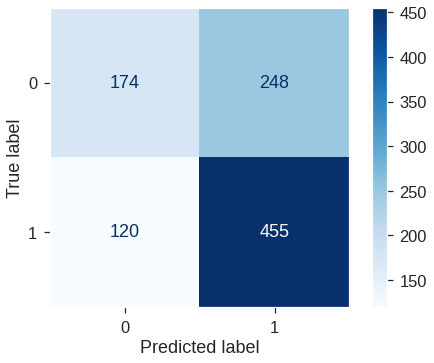

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    m1_lr,               # El primer argumento corresponde al modelo entrenado
    X_test,              # El segundo argumento corresponde a la matriz de datos de test sobre la cual se hará predicciones
    y_test,              # El tercer argumento corresponde al vector de datos test que contiene las etiquetas verdaderas de las observaciones
    cmap="Blues"         # Permite cambiar la paleta de colores
);

# Elimina la grilla de líneas blancas verticales y horizontales
plt.grid(False);

- **Verdaderos Positivos**: El modelo hizo 455 predicciones _correctas_ indicando que las personas _sí_ se cambiarían de pozo.
- **Verdaderos Negativos**: El modelo hizo 174 predicciones _correctas_ indicando que las personas _no_ se cambiarían de pozo.
- **Falsos Positivos**: El modelo hizo 248 predicciones _incorrectas_ indicando que las personas _sí_ se cambiarían de pozo, cuando _no lo hicieron_ en realidad.
- **Falsos Negativos**: El modelo hizo 120 predicciones _incorrectas_ indicando que las personas _no_ se cambiarían de pozo, cuando _sí lo hicieron_ e realidad.

### Accuracy
**Exactitud**: Casos correctamente predichos del total de observaciones.

$$
\begin{align}
\text{Accuracy} &= \frac{\text{VP} + \text{VN}}{\text{VP} + \text{VN} + \text{FP} + \text{FN}} \\
&= \frac{\text{# Predicciones correctas}}{\text{# Predicciones totales}}
\end{align}
$$
<br />
<br />
- La medida de exactitud por sí sola es engañosa, dado que no hace distinción alguna frente a los tipos de errores (Falso Negativo y Falso Positivo).
- Sus valores van entre 0 y 1, siendo 1 la máxima exactitud.
- Es una mala medida frente a clases desbalanceadas, cuando lo que se busca es evaluar el desempeño del modelo frente a la predicción de la clase minoritaria.
- En Python se puede obtener con `accuracy_score` de `sklearn.metrics`

In [25]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(
    y_test,        # Como primer argumento se entrega el vector de datos test que contiene las etiquetas verdaderas de las observaciones
    y_hat          # Como segundo argumento se entrega las predicciones (de clase) hechas por el modelo
)

assert acc == (174 + 455) / (174 + 455 + 248 + 120)

print(f"La exactitud del modelo entrenado es de {round(acc, 2)}")

La exactitud del modelo entrenado es de 0.63


### Precision

**Precisión**: Etiquetas correctas en las positivas.

$$
\text{Precision} = \frac{\text{VP}}{\text{FP} + \text{VP}}
$$

- Valores altos significan que el algoritmo predice más resultados relevantes que irrelevantes.
- Sus valores van entre 0 y 1, siendo 1 la máxima precisión.
- Responde a la pregunta: **¿Qué proporción de identificaciones positivas fue correcta?**.
- No se afecta por clases desbalanceadas, ya que solo considera las observaciones de la clase _positiva_ (usualmente "clase 1") y sus falsas predicciones.
<br />
<br />

- En Python se puede obtener con `precision_score` de `sklearn.metrics`
    - Existen otros "sabores" para esta métrica, que permite también considerar la clase "negativa" (clase 0), calculando un _promedio_. 
    - Para más información, revisar en la <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html">documentación</a> sobre el parámetro "average".

In [26]:
from sklearn.metrics import precision_score

prec = precision_score(y_test, y_hat)

print(f"La precisión del modelo entrenado es de {round(prec, 2)}")

La precisión del modelo entrenado es de 0.65


### Recall

**Recall**: Verdaderos positivos entre todos los positivos.

$$
\text{Recall} = \frac{\text{VP}}{\text{VP} + \text{FN}}
$$

- Valores altos significan que el algoritmo logra predecir la mayoría de los resultados relevantes.
- Sus valores van entre 0 y 1, siendo 1 el máximo recall.
- Responde a la pregunta: **¿Qué proporción de positivos reales se identificó correctamente?**.
- No se afecta por clases desbalanceadas, ya que solo considera las observaciones de la clase _positiva_ predichas y reales.
<br />
<br />
- Es la métrica de elección frente a casos en que **es relavante considerar los falsos negativos**. **Ejemplo**: 
    - Si se construye un modelo que predice la presencia de tumores cancerígenos, se escogerá aquel con _mayor recall_, ya que esto significa que su cantidad de predicciones de _falsos negativos_ es baja en comparación a un modelo con un bajo recall
    - Sería _muy grave_ indicarle a una persona _equivocadamente_ que _no_ tiene un tumor cuando _sí_ lo tiene, versus a indicarle equivocadamente que _sí_ tiene un tumor cuando realmente _no_ lo tiene.
<br />
<br />

- En Python se puede obtener con `recall_score` de `sklearn.metrics`
   - Al igual que precision, se puede modificar el parámetro `average`. Se puede consultar la <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html">documentación</a>.

In [27]:
from sklearn.metrics import recall_score

rec = recall_score(y_test, y_hat)

print(f"El recall del modelo entrenado es de {round(rec, 2)}")

El recall del modelo entrenado es de 0.79


### F1

- Existe un trueque entre Precision y Recall, en la medida que ambos puntajes se pueden promediar para obtener una medida ponderada de ambos fenómenos.
- Esta medida se conoce como **F1**, y representa la _media armónica_ entre Precisión y Recall. Se prefiere la media armónica dado que penaliza de mayor manera los valores bajos.
- F1 alcanza un máximo de 1 cuando Precision y Recall son 1, y 0 cuando Precisión _o_ Recall son 0, aún cuando una de las dos medidas sea 1.
- Se utiliza ésta dado que pondera de mayor manera a los valores bajos. Esto genera que el F1 sea alto sólo cuando precision y recall lo sean.

$$
\text{F1} = \frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$
<br />
<br />
- En Python se puede obtener con `f1_score` de `sklearn.metrics`.
   - También permite modificar el parámetro `average`. Se puede consultar la <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">documentación</a>.

In [28]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_hat)

print(f"El f1 del modelo entrenado es de {round(f1, 2)}")

El f1 del modelo entrenado es de 0.71


- En Python además es posible observar todas estas métricas utilizando `classification_report` de `sklearn.metrics`.

In [29]:
from sklearn.metrics import classification_report

# Se debe ingresar dentro de print
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.59      0.41      0.49       422
           1       0.65      0.79      0.71       575

    accuracy                           0.63       997
   macro avg       0.62      0.60      0.60       997
weighted avg       0.62      0.63      0.62       997



### Curva ROC

- Permite evaluar el rango de errores del modelo.
- Evalúa la relación entre falsos positivos y verdaderos positivos.
    - En el eje X va la tasa de Falsos Positivos (falsas alarmas).
    - En el eje Y va la tasa de Verdaderos Positivos.
    - La línea bisectriz representa el benchmark predictivo del modelo: esto es lo que esperamos si es que un clasificador asigna etiquetas de forma aleatoria, sin mayor información ingresada por el sistema.
    
<br />
<br />

- En Python, para generar un gráfico de curva ROC con `sklearn`, utilizamos el método `roc_curve` dentro del módulo metrics.
- **IMPORTANTE**: Recibe como argumento las predicciones de _probabilidad_, NO las de clase.

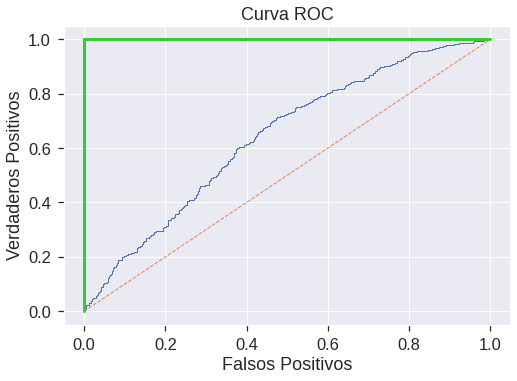

In [30]:
from sklearn.metrics import roc_curve

false_positive, true_positive, _ = roc_curve(
    y_test,                # Como primer argumento se entrega el vector de datos test que contiene las etiquetas verdaderas de las observaciones
    predicted_probs[:, 1]  # Como segundo argumento se entregan las predicciones de probabilidad, solamente de la clase positiva
)

# Plot ROC curve
plt.title('Curva ROC')
plt.plot(false_positive, true_positive, lw=1)
plt.plot([0, 1], ls="--", lw=1)
plt.plot([0, 0], [1, 0] , c='limegreen', lw=3), plt.plot([1, 1] , c='limegreen', lw=3)
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos');

- Una curva ROC con capacidad predictiva adecuada siempre se posicionará por sobre la bisectriz
- El comportamiento deseado de la curva ROC es que tienda a acercarse a la esquina superior izquierda del gráfico, señalada con verde.
- La calidad de una curva ROC también se puede resumir con una métrica simple llamada la área debajo de la curva.
    - Los valores mayores de esta cifra van a estar asociados con un mejor desempeño del modelo en predecir más verdaderos positivos que falsos positivos.
    - Sus valores van entre 0 y 1, siendo 1 la situación donde se logra predecir todos los verdaderos positivos.
    - En Python se obtiene con el método `roc_auc_score` de `sklearn.metrics`.

In [31]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, predicted_probs[:, 1])

print(f"El área bajo la curva ROC es de {round(auc, 2)}")

El área bajo la curva ROC es de 0.64


- El resultado de la curva ROC puede ser engañoso para clases desbalanceadas con alto sesgo y pocas observaciones de la clase minoritaria. Esto ya que un pequeño número de predicciones correctas o incorrectas puede resultar en un gran cambio en la curva ROC o en el score AUC.

# Validación Cruzada

## Motivación

- **Situación común**: no existen suficientes observaciones como para generar un estadístico de prueba robusto.
- **Solución**: Iterar de forma sucesiva simulando el entrenamiento del modelo en múltiples muestras.
- Por cada muestra se estima una métrica de desempeño. Luego se promedia las métricas de las distintas muestras.
- Es útil cuando no se tiene muchos datos, y no se quiere "desaprovechar" datos para entrenar, pero en general siempre se utiliza.

### K-Fold Cross Validation

- Se divide los datos en $k$ muestras.
- Se entrena el modelo con todas las submuestras a excepción de 1, que se utiliza para test.
- Se obtiene la métrica de desempeño utilizando la submuestra reservada para test.
- Se vuelve a entrenar y evaluar, cambiando el subset de muestra.

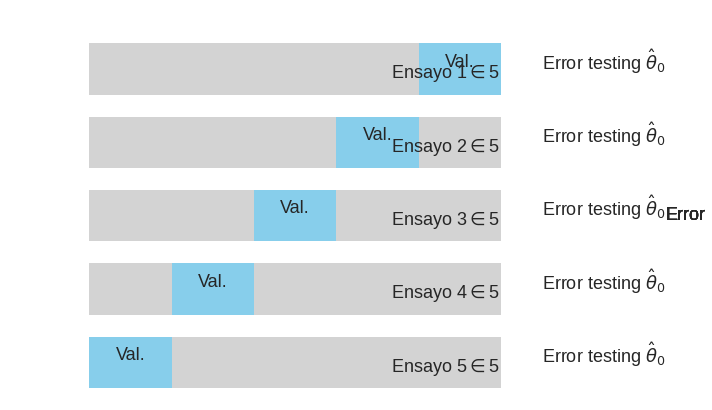

In [31]:
crossvalidation_schema()

### Leave One Out Cross Validation

- Versión extrema de K-Fold Cross Validation.
- Generamos tantos modelos con (n-1) observaciones como observaciones existan en una muestra.
- Es _muy costoso_ computacionalmente.


### ¿Y qué es mejor?
- Dependerá del caso a caso; En una muestra muy pequeña, se podría usar LOO-CV.
- En general se utiliza _k-fold_, con $k=10$ a $k=20$, pero incluso en este curso utilizaremos generalmente $k=5$, debido al costo computacional.
- Se debe considerar que si el modelo es muy complejo (ej: incluye términos polinomiales), eso también añade un costo computacional, demorando aún más el tiempo de entrenamiento.

- La implementación en Python se verá en detalle en el módulo de Machine Learning. Se aplica en conjunto con la _búsqueda de grilla_ de los hiperparámetros en los modelos de aprendizaje de máquinas.